<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Copy_of_Top_Left_of_Inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Try to connect to a GPU instance if you can

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import random
tfd = tfp.distributions

In [ ]:
# This is a direct solver specifically for matrices that are zeroed out
# under the band under the main diagonal and it only computes
# first column of inverse.

def dot(a, b):
  return tf.einsum('...i,...i->...', a, b)

def invert(m):
  n = m.shape[0]
  z = m[n - 1, n - 2:]
  for i in range(n - 1, 1, -1):
    z = tf.concat([[dot(m[i - 1, i - 1:], z)],
                   -m[i - 1, i - 2] * z], axis=0)

  z = z / dot(m[0], z)

  return z

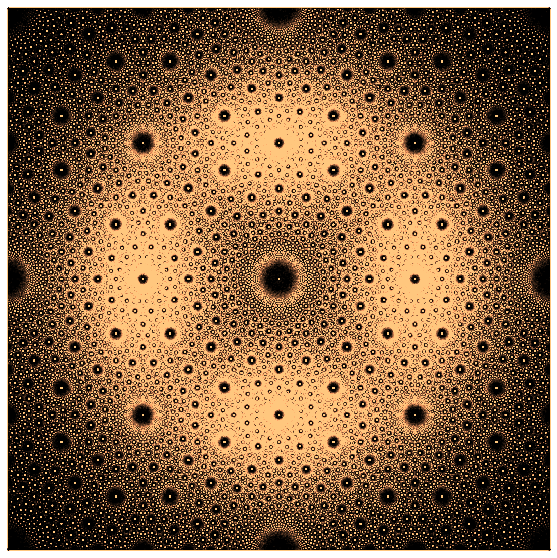

In [ ]:
n = 500000
d = 8
size = 2048
p = 4
iters = 40
r = 1.0

result = tf.zeros((size, size))
source = tf.Variable(tf.zeros((size, size)))

for i in range(iters):
  m = tfd.Categorical(tf.zeros(p)).sample((n, d, d))
  m = tf.exp((2. / p) * np.pi * 1j * tf.cast(m, tf.complex64))
  m = tf.cast(m, tf.complex64)
  m = tf.linalg.band_part(m, 1, -1)  # zero out lower bands
  u = tf.vectorized_map(invert, m)[..., 0]
  q = tf.stack([tf.math.real(u), tf.math.imag(u)], -1)

  with tf.GradientTape() as tape:
    dest = tf.reduce_sum(tfp.math.batch_interp_regular_nd_grid(q, [-r, -r], [r, r], source, axis=-2))
  image = tape.gradient(dest, source)
  result += image

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(result, vmin=0, vmax=1.0, cmap='copper')